In [1]:
import os
path = os.path.join('/home/scuervo/Documents/dev/reservoirpy')
import sys
sys.path.insert(0,path)

import numpy as np
from datetime import date, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from reservoirpy.wellproductivitypy import decline as dc
import seaborn as sns
from scipy import stats

# Declination Object

Create a declination Object by setting the parameters

In [2]:
qi = 680 #bbl/d
di = 0.28 #Annual declination in fraction
ti = date(2020,5,1) #Time for initial flow
b = 0

c = dc.Declination(qi=qi,di=di,ti=ti)
print(c)

Exponential Declination 
 Ti: 2020-05-01 
 Qi: 680 bbl/d 
 Rate: 0.28 Annually 
 b: 0


In [3]:
fr,cum = c.forecast(date(2020,2,1),date(2025,12,31),fq='1d')
print(fr)
print('Cummulative production is: ', np)

                qo      vo         np
time                                 
2020-02-01  728.61  728.61     728.61
2020-02-02  728.05  728.05    1456.65
2020-02-03  727.49  727.49    2184.14
2020-02-04  726.93  726.93    2911.08
2020-02-05  726.37  726.37    3637.45
...            ...     ...        ...
2025-12-26  139.49  139.49  768391.37
2025-12-27  139.38  139.38  768530.75
2025-12-28  139.27  139.27  768670.03
2025-12-29  139.17  139.17  768809.20
2025-12-30  139.06  139.06  768948.26

[2160 rows x 3 columns]
Cummulative production is:  <module 'numpy' from '/home/scuervo/anaconda3/envs/res/lib/python3.8/site-packages/numpy/__init__.py'>


In [4]:
c.forecast()

(                qo        vo         np
 time                                   
 2020-05-31  664.53  19935.88   19935.88
 2020-06-30  649.41  20131.73   40067.61
 2020-07-31  634.15  19658.63   59726.25
 2020-08-31  619.25  18577.40   78303.65
 2020-09-30  605.16  18759.91   97063.55
 2020-10-31  590.94  17728.11  114791.66
 2020-11-30  577.49  17902.27  132693.93
 2020-12-31  563.92  17481.56  150175.49
 2021-01-31  550.67  15418.73  165594.22
 2021-02-28  538.97  16707.98  182302.20
 2021-03-31  526.30  15789.04  198091.24,
 198091.24)

In [5]:
fr, cum = c.forecast(econ_limit=300, fq='1m')
print(fr)
print('Cummulative ',np)

                qo        vo         np
time                                   
2020-05-31  664.53  19935.88   19935.88
2020-06-30  649.41  20131.73   40067.61
2020-07-31  634.15  19658.63   59726.25
2020-08-31  619.25  18577.40   78303.65
2020-09-30  605.16  18759.91   97063.55
2020-10-31  590.94  17728.11  114791.66
2020-11-30  577.49  17902.27  132693.93
2020-12-31  563.92  17481.56  150175.49
2021-01-31  550.67  15418.73  165594.22
2021-02-28  538.97  16707.98  182302.20
2021-03-31  526.30  15789.04  198091.24
2021-04-30  514.33  15944.15  214035.38
2021-05-31  502.24  15067.22  229102.60
2021-06-30  490.81  15215.24  244317.84
2021-07-31  479.28  14857.67  259175.51
2021-08-31  468.02  14040.50  273216.01
2021-09-30  457.37  14178.43  287394.44
2021-10-31  446.62  13398.61  300793.06
2021-11-30  436.46  13530.24  314323.30
2021-12-31  426.20  13212.28  327535.58
2022-01-31  416.19  11653.23  339188.81
2022-02-28  407.34  12627.62  351816.42
2022-03-31  397.77  11933.10  363749.52


<AxesSubplot:xlabel='time'>

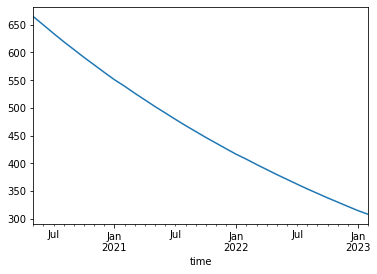

In [6]:
fr['qo'].plot()

## Fit real production data to declination

In [7]:
from sqlalchemy import create_engine

## Set up Database 
Username='postgres'
Password='Fenicia1703'
Host='localhost'
db_name='cedco'
connect_database='postgresql://{}:{}@{}/{}'.format(Username,Password,Host,db_name)

engine = create_engine(connect_database)

<AxesSubplot:>

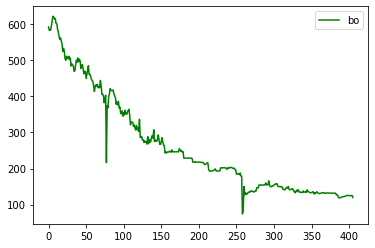

In [8]:
query = """
    select w.well, p.date, p.bo
    from production p
    join wells w on p.well_id = w.id
    where w.well = 'CANACABARE-3' and p.date >= DATE '2019-09-01' and p.bo>0
    order by p.date
"""

prod = pd.read_sql(query,engine)
prod.head()
prod.plot(color='green')

In [9]:
prod

,well,date,bo
0,CANACABARE-3,2019-09-01,591.662488
1,CANACABARE-3,2019-09-02,582.793308
2,CANACABARE-3,2019-09-03,582.466135
3,CANACABARE-3,2019-09-04,583.804090
4,CANACABARE-3,2019-09-05,598.191882
...,...,...,...
401,CANACABARE-3,2020-10-21,124.634573
402,CANACABARE-3,2020-10-22,125.040549
403,CANACABARE-3,2020-10-23,125.094819
404,CANACABARE-3,2020-10-24,124.910909


In [64]:
def zscore(x:np.ndarray,y:np.ndarray,thld:float=2)->np.ndarray:
    """zscore. Filter for time series production. Estimate the first order derivative of
    the natural logaritmic of rate with respect to time. Return a numpy array of zeros with
    the points greater than the threshold with one.

    Parameters
    ----------
    x : np.ndarray
        [description]
    y : np.ndarray
        [description]
    thld : float, optional
        [description], by default 2

    Returns
    -------
    np.ndarray
        [description]
    """
    
    ## Assert x and y have the same shape
    assert x.shape == y.shape
    
    index = np.zeros(x.shape)
    
    try:
        x = x.apply(lambda x: x.toordinal())
    except Exception as e:
        x = x.astype(float)

    
    # Logaritmic of rates
    logy = np.log(y)
    
    #Derivative
    dev = np.diff(logy) / np.diff(x)
    dev = np.append(dev[0],dev)
    #Estimate z Score
    abs_zscore=np.abs(stats.zscore(dev))
    
    index[abs_zscore>thld] = 1
    
    return index

6.0

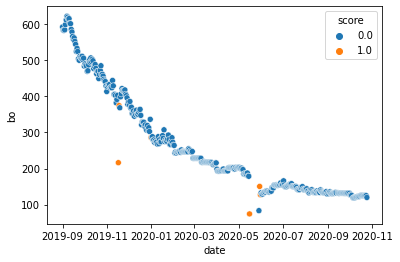

In [66]:
prod['score'] = zscore(prod['date'],prod['bo'])
sns.scatterplot(data=prod, x='date',y='bo',hue='score')
prod['score'].sum()

In [75]:
a = np.array([0,0,0,1,1,0,0,0,1,0,0,0])

a[a==0] = np.full(9,9)
a

array([9, 9, 9, 1, 1, 9, 9, 9, 1, 9, 9, 9])

mu = -0.004169703836146969
std=0.07174657262126657


/home/scuervo/anaconda3/envs/res/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/scuervo/anaconda3/envs/res/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


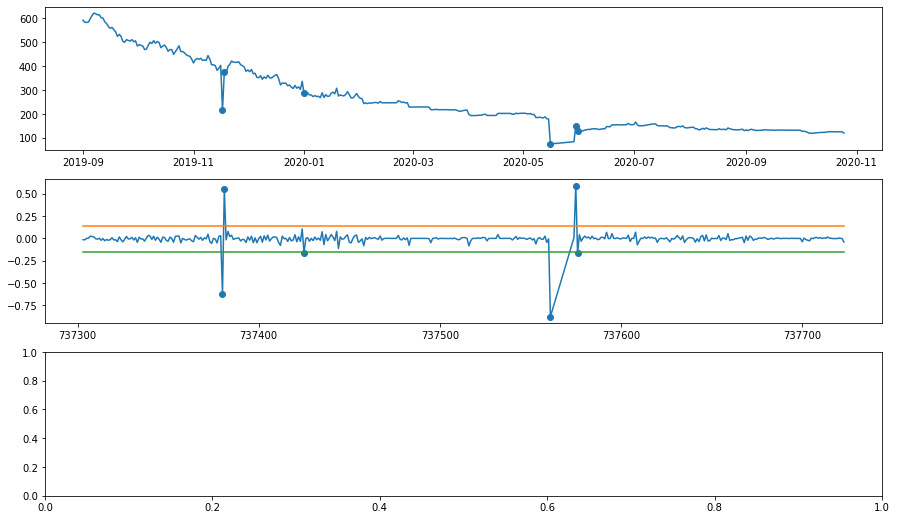

In [36]:
range_time = prod['date']
flow_rate=prod['bo']
tnum = range_time.apply(lambda x: x.toordinal()) 
lnq = np.log(flow_rate)
slp = np.diff(lnq) / np.diff(tnum)
slp = np.append(slp[0],slp)
mu = slp.mean()
sig = slp.std()

print(f'mu = {mu}\nstd={sig}')
abs_zscore=np.abs(stats.zscore(slp))

thr=2


fig,ax = plt.subplots(3,1, figsize=(15,9))

ax[0].plot(range_time,flow_rate)
ax[0].scatter(range_time[abs_zscore>thr],flow_rate[abs_zscore>thr])
ax[1].plot(tnum,slp)
ax[1].scatter(tnum[abs_zscore>thr],slp[abs_zscore>thr])
#ax[1].scatter(tnum[np.abs(slp)>mu+2*sig],slp[np.abs(slp)>mu+2*sig],color='red')



In [71]:
callable(range_time)

False

/home/scuervo/anaconda3/envs/res/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/scuervo/anaconda3/envs/res/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


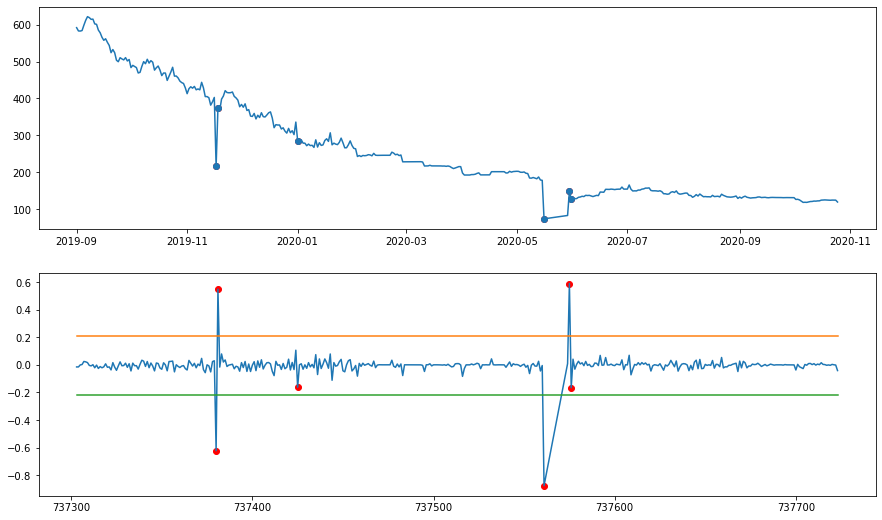

In [37]:
range_time = prod['date']
flow_rate=prod['bo']
tnum = range_time.apply(lambda x: x.toordinal()) 
lnq = np.log(flow_rate)
slp = np.diff(lnq) / np.diff(tnum)
slp = np.append(slp[0],slp)
mu = slp.mean()
sig = slp.std()
range_timef = range_time[np.abs(slp)>mu+2*sig]
flow_ratef = flow_rate[np.abs(slp)>mu+2*sig]
fig,ax = plt.subplots(2,1, figsize=(15,9))

ax[0].scatter(range_timef,flow_ratef, color='red')
ax[0].plot(range_time,flow_rate)
ax[0].scatter(range_timef,flow_ratef)
ax[1].plot(tnum,slp)
ax[1].scatter(tnum[np.abs(slp)>mu+2*sig],slp[np.abs(slp)>mu+2*sig],color='red')
ax[1].plot([tnum[0],tnum[-1:]],np.full(2,mu+3*sig))
ax[1].plot([tnum[0],tnum[-1:]],np.full(2,mu-3*sig))


In [11]:
c3 = dc.declination()
c3.fit(prod,time='date',rate='bo',xstd=3)
c3

Shape of input dataframe  348
Revome 4 rows by anomalies
new shape 344


Hyperbolic Declination 
 Ti: 2019-09-01 
 Qi: 618.7532944409021 bbl/d 
 Rate: 2.3873637756327684 Annually 
 b: 0.43878540285583745

In [12]:
f,cum=c3.forecast(end_date=date(2020,5,1),fq='D')
f

,qo,np
time,,
2019-09-01,618.75,618.75
2019-09-02,614.73,1233.48
2019-09-03,610.73,1844.21
2019-09-04,606.78,2450.99
2019-09-05,602.86,3053.86
...,...,...
2020-04-27,188.17,82543.24
2020-04-28,187.44,82730.68
2020-04-29,186.72,82917.40


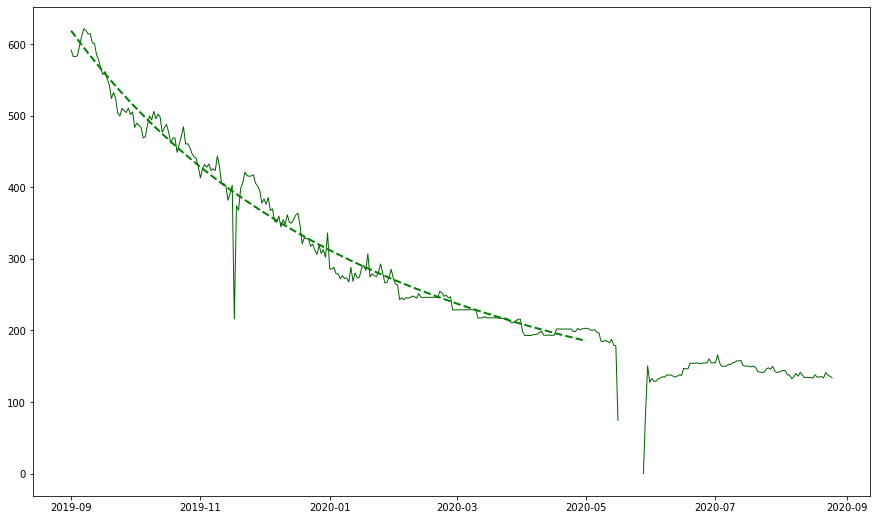

In [13]:
fig, ax = plt.subplots(figsize=(15,9))

ax.plot(prod['date'], prod['bo'], linewidth = 1, color='darkgreen')
ax.plot(f.index, f['qo'], linewidth = 2, linestyle='--', color='green')
#ax.scatter(a['date'],a['bo'],color=(0.1,0.9,0.5),s=155)

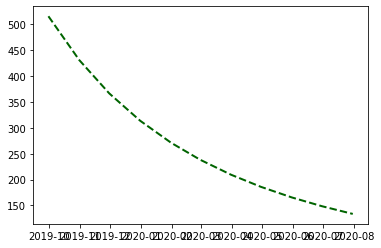

In [14]:
c3.plot()

# Econ Limit

In [15]:
qi = 680 #bbl/d
di = 0.28 #Annual declination in fraction
ti = date(2020,5,1) #Time for initial flow
b = 0
ec = 600


c4 = dc.declination(qi=qi,di=di,ti=ti, econ_limit=ec)
print(c4)

Exponential Declination 
 Ti: 2020-05-01 
 Qi: 680 bbl/d 
 Rate: 0.28 Annually 
 b: 0


In [16]:
c4.forecast(end_date=date(2023,12,31),econ_limit=400)

(                qo         np
 time                         
 2020-05-31  664.53     664.53
 2020-06-30  649.41   20146.85
 2020-07-31  634.15   39805.48
 2020-08-31  619.25   59002.13
 2020-09-30  605.16   77156.88
 2020-10-31  590.94   95475.92
 2020-11-30  577.49  112800.70
 2020-12-31  563.92  130282.26
 2021-01-31  550.67  147353.00
 2021-02-28  538.97  162444.08
 2021-03-31  526.30  178759.41
 2021-04-30  514.33  194189.23
 2021-05-31  502.24  209758.69
 2021-06-30  490.81  224483.11
 2021-07-31  479.28  239340.79
 2021-08-31  468.02  253849.30
 2021-09-30  457.37  267570.36
 2021-10-31  446.62  281415.60
 2021-11-30  436.46  294509.38
 2021-12-31  426.20  307721.66
 2022-01-31  416.19  320623.45
 2022-02-28  407.34  332029.04,
 332029.04)

In [17]:
qi = 680 #bbl/d
di = 0.28 #Annual declination in fraction
ti = date(2020,5,1) #Time for initial flow
b = 0
ec = 100
npl = 200000

c5 = dc.declination(qi=qi,di=di,ti=ti, econ_limit=ec, np_limit=npl)
print(c5)

Exponential Declination 
 Ti: 2020-05-01 
 Qi: 680 bbl/d 
 Rate: 0.28 Annually 
 b: 0


In [18]:
c5.forecast(fq='5d')

(                qo         np
 time                         
 2020-05-01  680.00     680.00
 2020-05-06  677.40    4066.98
 2020-05-11  674.80    7441.00
 2020-05-16  672.22   10802.10
 2020-05-21  669.65   14150.34
 ...            ...        ...
 2021-03-07  536.08  187929.61
 2021-03-12  534.03  190599.75
 2021-03-17  531.98  193259.67
 2021-03-22  529.95  195909.41
 2021-03-27  527.92  198549.00
 
 [67 rows x 2 columns],
 198549.0)

In [19]:
c5.forecast(fq='5d',show_water=True, fluid_rate=4700, econ_limit=100)

(                qo         np       qw       bsw       wor     wor_1
 time                                                                
 2020-05-01  680.00     680.00  4020.00  0.855319  5.911765  6.911765
 2020-05-06  677.40    4066.98  4022.60  0.855872  5.938293  6.938293
 2020-05-11  674.80    7441.00  4025.20  0.856426  5.965027  6.965027
 2020-05-16  672.22   10802.10  4027.78  0.856974  5.991759  6.991759
 2020-05-21  669.65   14150.34  4030.35  0.857521  6.018592  7.018592
 ...            ...        ...      ...       ...       ...       ...
 2021-03-07  536.08  187929.61  4163.92  0.885940  7.767348  8.767348
 2021-03-12  534.03  190599.75  4165.97  0.886377  7.801004  8.801004
 2021-03-17  531.98  193259.67  4168.02  0.886813  7.834919  8.834919
 2021-03-22  529.95  195909.41  4170.05  0.887245  7.868761  8.868761
 2021-03-27  527.92  198549.00  4172.08  0.887677  7.902864  8.902864
 
 [67 rows x 6 columns],
 198549.0)

In [20]:
qi = 680 #bbl/d
di = 0.28 #Annual declination in fraction
ti = date(2020,5,1) #Time for initial flow
b = 0


c6 = dc.declination(qi=qi,di=di,ti=ti)
print(c6)

Exponential Declination 
 Ti: 2020-05-01 
 Qi: 680 bbl/d 
 Rate: 0.28 Annually 
 b: 0


In [21]:
c6.forecast(econ_limit=10)

(                qo         np
 time                         
 2020-05-31  664.53     664.53
 2020-06-30  649.41   20146.85
 2020-07-31  634.15   39805.48
 2020-08-31  619.25   59002.13
 2020-09-30  605.16   77156.88
 ...            ...        ...
 2034-12-31   11.16  842462.82
 2035-01-31   10.90  842800.74
 2035-02-28   10.67  843099.48
 2035-03-31   10.42  843422.45
 2035-04-30   10.18  843727.89
 
 [180 rows x 2 columns],
 843727.89)